In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps,io,stats,cosmology,lensing


In [15]:
from peakaboo import utils
LC = utils.LiuConvergence(root_dir="/gpfs01/astro/workarea/msyriac/data/sims/jia/massless/")
cc = cosmology.Cosmology(lmax=4000,pickling=True,dimensionless=False)

Generating theory Cls...


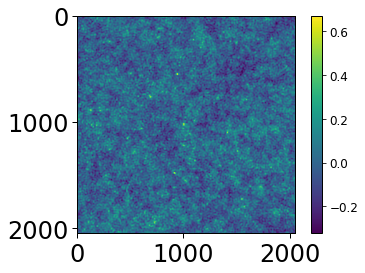

In [10]:
k1 = LC.get_kappa(1)
io.plot_img(k1)

In [35]:

N = 100
shape,wcs = k1.shape,k1.wcs
modlmap = enmap.modlmap(shape,wcs)
fc = maps.FourierCalc(shape,wcs)
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
ps = cc.theory.gCl('kk',ells).reshape((1,1,ells.size))
mgen = maps.MapGen(shape,wcs,ps)
bin_edges = np.arange(100,3000,100)
binner = stats.bin2D(modlmap,bin_edges)
st = stats.Stats()
for i in range(1,N+1):
    if (i+1)%10==0: print(i+1)
    kappa = LC.get_kappa(i+1)
    gsim = mgen.get_map()
    p2d,_,_ = fc.power2d(kappa)
    p2dg,_,_ = fc.power2d(gsim)
    cents,p1d = binner.bin(p2d)
    cents,p1dg = binner.bin(p2dg)
    st.add_to_stats("kappa",p1d)
    st.add_to_stats("gsim",p1dg)
    
st.get_stats() 

10
20
30
40
50
60
70
80
90
100


In [36]:
area,frac = maps.area_from_mask(enmap.ones(shape,wcs))
fsky = area / 41252.
LF = cosmology.LensForecast()
LF.loadKK(ells,ps[0,0],ells,ps[0,0]*0.)
sn,errs = LF.sn(bin_edges,fsky,"kk")

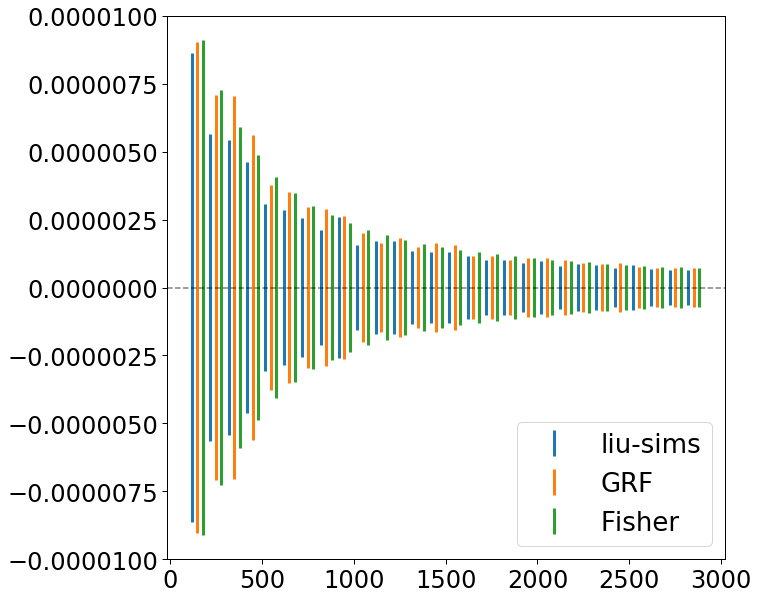

In [37]:
errk = st.stats["kappa"]["err"]
errg = st.stats["gsim"]["err"]
cents = binner.centers

pl = io.Plotter(figsize=(10,10))
pl.add_err(cents-30,cents*0.,yerr=errk*cents,label="liu-sims",elinewidth=3)
pl.add_err(cents,cents*0.,yerr=errg*cents,label="GRF",elinewidth=3)
pl.add_err(cents+30,cents*0.,yerr=errs*cents,label="Fisher",elinewidth=3)
pl.hline()
pl.legend(loc='lower right',labsize=26)
pl.done()

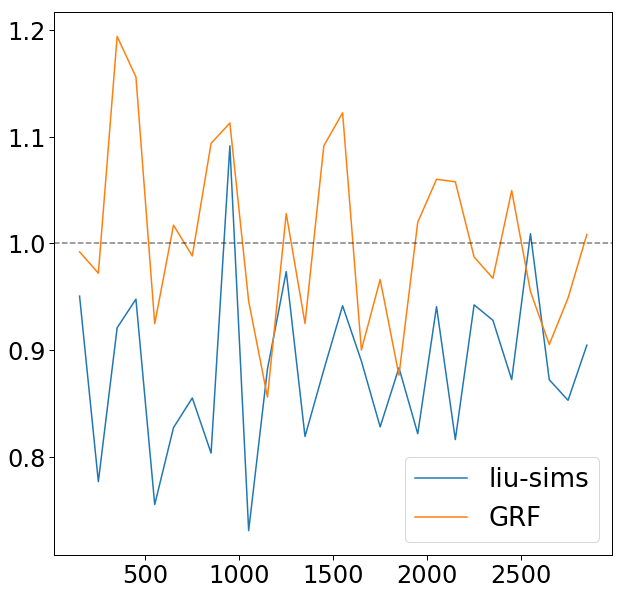

In [44]:
pl = io.Plotter(figsize=(10,10))
pl.add(cents,errk/errs,label="liu-sims")
pl.add(cents,errg/errs,label="GRF")
pl.hline(y=1.0)
pl.legend(loc='lower right',labsize=26)
pl.done()

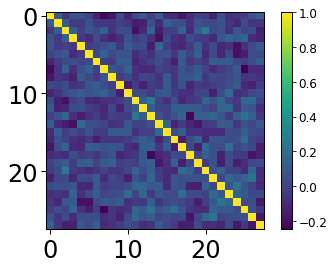

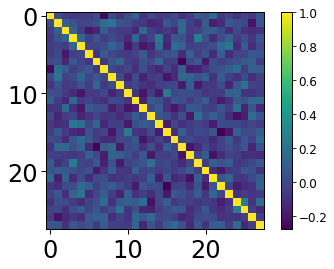

In [41]:
io.plot_img(stats.cov2corr(st.stats["kappa"]["cov"]),flip=False)
io.plot_img(stats.cov2corr(st.stats["gsim"]["cov"]),flip=False)